In [1]:
import pandas as pd

### 1. 

In [1]:
tool = pd.read_excel('./신스윈툴교체.xlsx')

NameError: name 'pd' is not defined

In [19]:
tool.nunique()

primarykey        677
설비코드                1
정삭                  1
툴코드                 2
개수                203
inputdatetime     677
enddatetime       677
updatedatetime    677
mix                 2
제품코드               21
규격                389
dtype: int64

In [20]:
tool_select = tool[(tool['enddatetime']<=pd.Timestamp('2023-09-04 15:28:05.331000')) &(tool['enddatetime']>=pd.Timestamp('2023-08-22 15:26:18.991000'))]

In [26]:
pd.DataFrame(tool_select.nunique()).transpose()

,primarykey,설비코드,정삭,툴코드,개수,inputdatetime,enddatetime,updatedatetime,mix,제품코드,규격
0,78,1,1,1,55,78,78,78,2,3,57


In [21]:
tool_select.to_csv('tool.csv',index=False)

In [29]:
for column in ['개수','mix','제품코드','규격']:
    print(tool_select[column].value_counts())
    print()

개수
100    4
55     3
63     3
45     3
23     2
37     2
76     2
46     2
54     2
33     2
44     2
43     2
52     2
92     2
94     2
99     2
81     2
22     2
17     1
66     1
96     1
36     1
25     1
32     1
50     1
41     1
62     1
83     1
51     1
61     1
106    1
49     1
21     1
95     1
75     1
101    1
60     1
102    1
78     1
109    1
93     1
89     1
74     1
105    1
88     1
71     1
98     1
90     1
65     1
38     1
148    1
161    1
97     1
157    1
59     1
Name: count, dtype: int64

mix
N    77
Y     1
Name: count, dtype: int64

제품코드
FSCN-0062              45
FSCN-0066              32
FSCN-0062,FSCN-0066     1
Name: count, dtype: int64

규격
(APH025[100 EA])                 4
(APH031[45 EA])                  3
(APH031[63 EA])                  3
(APH031[55 EA])                  3
(APH025[81 EA])                  2
(APH031[37 EA])                  2
(APH031[22 EA])                  2
(APH025[76 EA])                  2
(APH025[99 EA])                  2


In [31]:
tool_select[tool_select['mix']=='Y']

,primarykey,설비코드,정삭,툴코드,개수,inputdatetime,enddatetime,updatedatetime,mix,제품코드,규격
45,2260,CNC01,T03,CT202,157,2023-08-28 15:42:15.037,2023-08-28 15:42:15.037,2023-08-28 15:42:15.037,Y,"FSCN-0062,FSCN-0066","(APH031[0 EA],APH025[157 EA])"


### 2. 

In [2]:
tool_62  = pd.read_csv('tool_62.csv',index_col=0)
tool_66  = pd.read_csv('tool_66.csv',index_col=0)

In [6]:
import numpy as np
def make_start_end(df:pd.DataFrame):
    dataframe = {}
    start = list(df['enddatetime'].iloc[1:])
    start.append(np.nan)
    dataframe['start'] = start
    dataframe['end'] = df['enddatetime']
    dataframe = pd.DataFrame(dataframe)
    dataframe.reset_index(drop=True,inplace=True)
    return dataframe

In [8]:
make_start_end(tool_62).to_csv('ch_62.csv',index=False)
make_start_end(tool_66).to_csv('ch_66.csv',index=False)

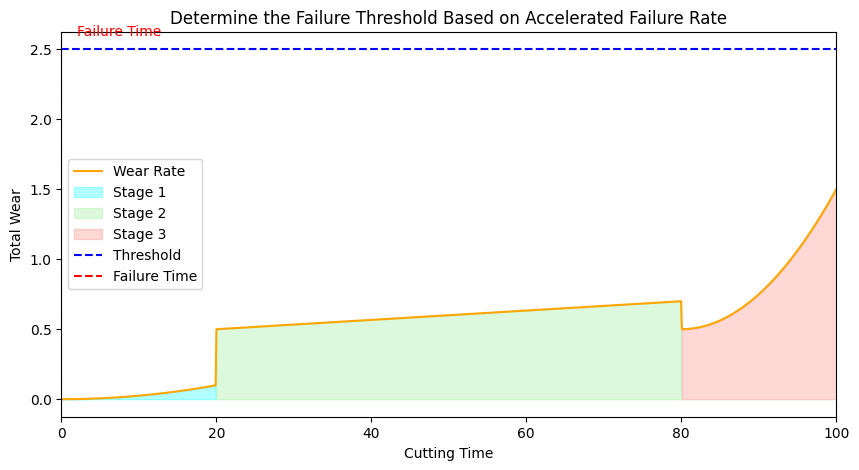

In [2]:
# Adjusting the simulation of the wear curve to ensure all phases connect smoothly and changing the x-axis range to 0-100
import numpy as np
import matplotlib.pyplot as plt
# Create a new range of cutting times
cutting_time = np.linspace(0, 100, 1000)  # increased the upper limit to 100

# Modify the piecewise functions to adjust the wear rate to the new cutting time range
# Initial wear phase (quadratic growth)
initial_wear_phase = (cutting_time < 20)
initial_wear_rate = 0.1 * (cutting_time**2 / 400)

# Normal wear phase (linear growth)
normal_wear_phase = (cutting_time >= 20) & (cutting_time < 80)
normal_wear_rate = 0.5 + (cutting_time - 20) / 300

# Severe wear phase (exponential growth)
severe_wear_phase = (cutting_time >= 80)
severe_wear_rate = 0.5 + (0.05 * (cutting_time - 80))**2

# Combine the phases
wear_rate = np.piecewise(cutting_time, [initial_wear_phase, normal_wear_phase, severe_wear_phase],
                         [lambda x: 0.1 * (x**2 / 400), 
                          lambda x: 0.5 + (x - 20) / 300, 
                          lambda x: 0.5 + (0.05 * (x - 80))**2])

# Determine the failure threshold
failure_threshold = 2.5  # Hypothetical value

# Find the cutting time where the wear rate first exceeds the failure threshold during severe wear
failure_time_index = np.argmax(wear_rate >= failure_threshold)
failure_time = cutting_time[failure_time_index]

# Re-plotting the graph with new annotations
plt.figure(figsize=(10, 5))
plt.plot(cutting_time, wear_rate, label='Wear Rate', color='orange')

# Highlighting the different wear phases with colors and renaming them
plt.fill_between(cutting_time, wear_rate, 0, where=initial_wear_phase, color='cyan', alpha=0.3, label='Stage 1')
plt.fill_between(cutting_time, wear_rate, 0, where=normal_wear_phase, color='lightgreen', alpha=0.3, label='Stage 2')
plt.fill_between(cutting_time, wear_rate, 0, where=severe_wear_phase, color='salmon', alpha=0.3, label='Stage 3')

# Drawing the failure threshold line
plt.axhline(y=failure_threshold, color='blue', linestyle='--', label='Threshold')

# Drawing the failure time line at the intersection with the threshold
plt.axvline(x=failure_time, color='red', linestyle='--', label='Failure Time')

# Annotating the failure time at the intersection with the threshold
plt.text(failure_time + 2, failure_threshold + 0.1, 'Failure Time', color='red', horizontalalignment='left')

# Adding titles and labels
plt.title('Determine the Failure Threshold Based on Accelerated Failure Rate')
plt.xlabel('Cutting Time')
plt.ylabel('Total Wear')
plt.xlim(0, 100)  # Set the x-axis limit to 0-100
plt.legend()

# Save the figure with the new annotations
plt.show()